# **1. 데이터 세팅**

데이터 출처 : http://know.tour.go.kr (관광정보시스템)

* 2018-2019년 자료
* 총 응답자(N) : 34,746명

###Data Describe

* ID 아이디

* SMONTH 여행 시작 월
* S_Day 여행일수(박)
* TCOST 여행 총경비
* TNUM 여행 인원
* ONE_TCOST 1인 지출비용
* CASE 여행유형
* SPOT 1번째 여행 1번째 방문지
---
* AG 여행사상품구매여부
* AGTYPE 여행사 상품 종류 (전체/부분)
* A2_1~3 여행지선택 이유 1-3순위
* A7B 동반자 유형
---
* PRE_TOTAL 여행전 지출 총합_1인
* NA10A 여행사 지출비용_1인
* NA10C 숙박비_1인
* NA10D 식비_1인
* NA10E 교통비_1인
* NA10F 여행활동비_1인
* NA10G 쇼핑비_1인
* NA10_TOTAL 여행지 지출 총합_1인
---
* RATING 전반적 만족도
* A13 재방문 의도
* A14 타인추천의도
---
* DQ5 월평균 가구 소득
* DQ6 월평균 본인 소득
* SEX 성별
* BAGE 연령대
* BARA 거주지역

In [204]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap
!conda install -c conda-forge shap
!conda install -c conda-forge shap

## **1-1 raw data  전처리**

In [603]:
!git clone https://github.com/kerobes97/Lets_Boot.git

fatal: destination path 'Lets_Boot' already exists and is not an empty directory.


In [604]:
!ls /content/Lets_Boot/Travel_Data/Datasets

'2018 국민여행조사_국내여행.xlsx'  'Data Describe'
'2019 국민여행조사_국내여행.xlsx'


In [605]:
import pandas as pd

df18 = pd.read_excel('/content/Lets_Boot/Travel_Data/Datasets/2018 국민여행조사_국내여행.xlsx')
df19 = pd.read_excel('/content/Lets_Boot/Travel_Data/Datasets/2019 국민여행조사_국내여행.xlsx') 
df18.shape,  df19.shape

((24154, 43), (48269, 38))

In [606]:
# #만족도 조사가 완료된 데이터만 사용
# 하려했으나 -> 만족도 편향이 너어어어무 심해서 안그러기로

# df18=df18.dropna(subset=['RATING'])
# df19=df19.dropna(subset=['RATING'])

In [607]:
#18년도 데이터 S_Day
df18['start'] = pd.to_datetime(dict(year=df18.D_TRA1_SYEAR, month=df18.D_TRA1_SMONTH, day=df18.D_TRA1_SDAY))
df18['end'] = pd.to_datetime(dict(year=df18.D_TRA1_EYEAR, month=df18.D_TRA1_EMONTH, day=df18.D_TRA1_EDAY))

df18['S_Day']= (df18['end'] - df18['start']).dt.days
df18.head(10)

,ID,MON_EXP_DOM_TOUR,MON_EXP_DOM_BUSIN,MON_EXP_DOM_FRI,D_TRA1_SYEAR,D_TRA1_SMONTH,D_TRA1_SDAY,D_TRA1_EYEAR,D_TRA1_EMONTH,D_TRA1_EDAY,TNUM,ONE_TCOST,CASE,SPOT,AG,AGTYPE,A2_1,A2_2,A2_3,A7B_1,A7B_2,A7B_3,A7B_4,A7B_5,A7B_6,PRE_TOTAL,NA10A,NA10C,NA10D,NA10E,NA10F,NA10G,NA_TOTAL,RATING,A13,A14,DQ5,DQ6,SEX,BAGE,BARA,EXP_NIGHT,EXP_ADAY,start,end,S_Day
0,11010560291_702520,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,9,1,3,11,0,0,NaT,NaT,NaN
1,11010560291_702521,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,6,2,4,11,0,0,NaT,NaT,NaN
2,11010560291_702526,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,99,2,2,11,0,0,NaT,NaT,NaN
3,11010560291_702539,1,2,2,2018.0,7.0,6.0,2018.0,7.0,8.0,5.0,360000.0,2.0,39.0,2.0,NaN,5.0,3.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,0.0,0.0,55214.723926,123680.981595,149079.754601,5521.472393,26503.067485,360000.0,4.0,5.0,4.0,12,99,2,6,11,1,0,2018-07-06,2018-07-08,2.0
4,11010560291_702558,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,7,1,5,11,0,0,NaT,NaT,NaN
5,11010560321_500005,1,2,2,2018.0,5.0,19.0,2018.0,5.0,19.0,33.0,57200.0,2.0,34.0,2.0,NaN,2.0,14.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,0.0,0.000000,4200.000000,10000.000000,3000.000000,10000.000000,57200.0,4.0,4.0,3.0,10,5,2,5,11,0,1,2018-05-19,2018-05-19,0.0
6,11010560321_500010,1,2,2,2018.0,5.0,8.0,2018.0,5.0,8.0,5.0,90000.0,2.0,31.0,2.0,NaN,12.0,4.0,14.0,NaN,NaN,3.0,NaN,NaN,NaN,0.0,0.0,0.000000,51373.390558,7725.321888,11587.982833,19313.304721,90000.0,4.0,4.0,4.0,8,8,1,7,11,0,1,2018-05-08,2018-05-08,0.0
7,11010560321_500015,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,99,1,1,11,0,0,NaT,NaT,NaN
8,11010560321_500023,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,6,1,3,11,0,0,NaT,NaT,NaN
9,11010560321_500029,1,2,2,2018.0,5.0,4.0,2018.0,5.0,6.0,5.0,68500.0,2.0,35.0,2.0,NaN,5.0,4.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.000000,44500.000000,24000.000000,0.000000,0.000000,68500.0,4.0,4.0,3.0,4,4,2,6,11,1,0,2018-05-04,2018-05-06,2.0


In [608]:
#18년도 여행 안간사람 제외
df18=df18[~df18['CASE'].isnull()]

#19년도 여행 안간사람 제외
df19=df19[~df19['CASE'].isnull()]

In [609]:
#18년도 TCOST
df18['TCOST']= df18['TNUM '] * df18['ONE_TCOST']

In [610]:
#여행유형 확인
df18['CASE'].unique(), df19['CASE'].unique()

(array([2., 4., 3.]), array([1., 5., 3., 4., 2.]))

In [611]:
#여행유형 통일
def case18(row):
  if row['CASE']==2:
    return 'trip'
  elif row['CASE']==3:
    return 'work'
  elif row['CASE']==4:
    return 'family'

def case19(row):
  if row['CASE']==1:
    return 'trip'
  elif row['CASE']==2:
    return 'trip'
  elif row['CASE']==3:
    return 'family'
  elif row['CASE']==4:
    return 'work'
  elif row['CASE']==5:
    return 'work'


df18['CASE'] = df18.apply(lambda row: case18(row), axis=1)
df19['CASE'] = df19.apply(lambda row: case19(row), axis=1)

df18['CASE'].unique(), df19['CASE'].unique()

(array(['trip', 'family', 'work'], dtype=object),
 array(['trip', 'work', 'family'], dtype=object))

In [612]:
#도시 번호 등록
df19['SPOT'] = df19['SPOT']/1000
df19['SPOT'] = df19['SPOT'].fillna(-1)
df19['SPOT'] = df19['SPOT'].astype(int)
df19['SPOT'] = df19['SPOT'].replace('-1', None)

In [613]:
df18.columns.unique(), df19.columns.unique()

(Index(['ID', 'MON_EXP_DOM_TOUR', 'MON_EXP_DOM_BUSIN', 'MON_EXP_DOM_FRI',
        'D_TRA1_SYEAR', 'D_TRA1_SMONTH', 'D_TRA1_SDAY', 'D_TRA1_EYEAR',
        'D_TRA1_EMONTH', 'D_TRA1_EDAY', 'TNUM ', 'ONE_TCOST', 'CASE', 'SPOT',
        'AG', 'AGTYPE', 'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2', 'A7B_3',
        'A7B_4', 'A7B_5', 'A7B_6', 'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D',
        'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 'RATING', 'A13', 'A14', 'DQ5',
        'DQ6', 'SEX', 'BAGE', 'BARA', 'EXP_NIGHT', 'EXP_ADAY', 'start', 'end',
        'S_Day', 'TCOST'],
       dtype='object'),
 Index(['ID', 'Q', 'SMONTH', 'S_Day', 'TCOST', 'TNUM', 'ONE_TCOST', 'CASE',
        'SPOT', 'AG', 'AGTYPE', 'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2',
        'A7B_3', 'A7B_4', 'A7B_5', 'A7B_6', 'PRE_TOTAL', 'NA10A', 'NA10C',
        'NA10D', 'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 'RATING', 'A13', 'A14',
        'DQ5', 'DQ6', 'SEX', 'BAGE', 'BARA', 'EXP_NIGHT', 'EXP_ADAY'],
       dtype='object'))

In [614]:
#데이터 피쳐명 통일
df18=df18[['ID', 'D_TRA1_SMONTH', 'S_Day', 'TCOST', 'TNUM ', 'ONE_TCOST', 'CASE', 'SPOT',
          'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2', 'A7B_3', 'A7B_4', 'A7B_5', 'A7B_6',
          'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D', 'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 
          'RATING', 'A13', 'A14', 'DQ5', 'DQ6', 'SEX', 'BAGE', 'BARA',
          'EXP_NIGHT', 'EXP_ADAY']]
df18.rename(columns = {'D_TRA1_SMONTH':'SMONTH', 'TNUM ':'TNUM'}, inplace = True)

df19=df19[['ID', 'SMONTH', 'S_Day', 'TCOST', 'TNUM', 'ONE_TCOST', 'CASE','SPOT', 
          'A2_1', 'A2_2', 'A2_3',  'A7B_1', 'A7B_2', 'A7B_3', 'A7B_4', 'A7B_5', 'A7B_6', 
          'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D', 'NA10E', 'NA10F', 'NA10G', 'NA_TOTAL', 
          'RATING', 'A13', 'A14', 'DQ5', 'DQ6', 'SEX', 'BAGE', 'BARA', 
          'EXP_NIGHT', 'EXP_ADAY']]

## **1-2 df data 전처리**

In [615]:
df=pd.concat([df18, df19])
# df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41624 entries, 3 to 48267
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         41624 non-null  object 
 1   SMONTH     41624 non-null  float64
 2   S_Day      41624 non-null  float64
 3   TCOST      39138 non-null  float64
 4   TNUM       39138 non-null  float64
 5   ONE_TCOST  41624 non-null  float64
 6   CASE       41624 non-null  object 
 7   SPOT       41624 non-null  float64
 8   A2_1       34615 non-null  float64
 9   A2_2       31595 non-null  float64
 10  A2_3       23594 non-null  float64
 11  A7B_1      18364 non-null  float64
 12  A7B_2      970 non-null    float64
 13  A7B_3      12359 non-null  float64
 14  A7B_4      775 non-null    float64
 15  A7B_5      2039 non-null   float64
 16  A7B_6      117 non-null    float64
 17  PRE_TOTAL  34615 non-null  float64
 18  NA10A      34615 non-null  float64
 19  NA10C      34615 non-null  float64
 20  NA10D 

In [616]:
df['CASE'].unique()

array(['trip', 'family', 'work'], dtype=object)

In [617]:
#중복값
df[df.duplicated()==True]

df=df.reset_index(drop=True)
df[df.index.duplicated()==True]

,ID,SMONTH,S_Day,TCOST,TNUM,ONE_TCOST,CASE,SPOT,A2_1,A2_2,A2_3,A7B_1,A7B_2,A7B_3,A7B_4,A7B_5,A7B_6,PRE_TOTAL,NA10A,NA10C,NA10D,NA10E,NA10F,NA10G,NA_TOTAL,RATING,A13,A14,DQ5,DQ6,SEX,BAGE,BARA,EXP_NIGHT,EXP_ADAY


In [618]:
#동행 유형 생성
def A7B (row):
  if row['A7B_1']==1:
    return 'Fam'
  elif row['A7B_2']==2:
    return 'B_Fam'
  elif row['A7B_3']==3:
    return 'Mate'
  elif (row['A7B_4']==4) & (row['A7B_6']==6):
    return 'Co'
  elif row['A7B_5']==5:
    return 'Crew'
  else:
    return 'Etc'

df['A7B'] = df.apply(lambda row: A7B(row), axis=1)
# df[df['A7B'].isnull()]
df['A7B'].unique()

array(['Mate', 'Crew', 'Fam', 'Etc', 'B_Fam'], dtype=object)

In [619]:
#여행 총지출 범주 생성
df['M_TOTAL']=df['PRE_TOTAL']+df['NA_TOTAL']
df['M_TOTAL']=df['M_TOTAL'].fillna(df['ONE_TCOST'])
df['M_TOTAL'].isnull().sum()
def money (row):
  if (row['M_TOTAL']>0) & (row['M_TOTAL']<=30000):
    return 1
  elif (row['M_TOTAL']>30000) & (row['M_TOTAL']<=50000):
    return 2
  elif (row['M_TOTAL']>50000) & (row['M_TOTAL']<=80000):
    return 3
  elif (row['M_TOTAL']>80000) & (row['M_TOTAL']<=110000):
    return 4
  elif (row['M_TOTAL']>110000) & (row['M_TOTAL']<=150000):
    return 5
  elif (row['M_TOTAL']>150000) & (row['M_TOTAL']<=200000):
    return 6
  elif (row['M_TOTAL']>200000) & (row['M_TOTAL']<=300000):
    return 7
  elif (row['M_TOTAL']>300000):
    return 8

df['BNA'] = df.apply(lambda row: money(row), axis=1)
# df[df['BNA'].isnull()]
df=df[~df['BNA'].isnull()]
df['BNA'].unique()

array([8., 3., 4., 5., 2., 6., 7., 1.])

In [620]:
df['BNA'].value_counts()

3.0    7642
2.0    7510
4.0    6801
5.0    4923
6.0    4417
1.0    4128
7.0    3496
8.0    2704
Name: BNA, dtype: int64

In [621]:
#숙박 여부 생성
def DnN (row):
  if row['EXP_NIGHT']==1:
    return 1
  elif row['EXP_ADAY']==1:
    return 0

df['DandN'] = df.apply(lambda row: DnN(row), axis=1)
df['DandN'].unique()

array([1, 0])

In [622]:
# import numpy as np
# df['A2_1'] = df['A2_1'].replace(np.nan, '', regex=True)

# df['A2_1'] = pd.to_numeric(df['A2_1'])
# df['A2_1'].dtype

In [623]:
#여행지 선정 이유 생성
def why (row):
  if row['A2_1']==1:
    return 'Famous'
  elif (row['A2_1']==2) or (row['A2_1']==6):
    return 'View'
  elif row['A2_1']==3:
    return 'Budget'
  elif (row['A2_1']==4) or (row['A2_1']==5) or (row['A2_1']==9):
    return 'Time/Trans'
  elif row['A2_1']==7:
    return 'Shopping'
  elif row['A2_1']==8:
    return 'Food'
  elif (row['A2_1']==10) or (row['A2_1']==13) or (row['A2_1']==9):
    return 'Edu'
  elif (row['A2_1']==11) or (row['A2_1']==14):
    return 'Rec'
  elif row['A2_1']==15:
    return 'Conv'
  else: return 'etc'

df['REASON'] = df.apply(lambda row: why(row), axis=1)
# df['REASON'].isnull().sum()
df['REASON'].unique()

array(['Time/Trans', 'View', 'etc', 'Food', 'Rec', 'Famous', 'Budget',
       'Edu', 'Conv', 'Shopping'], dtype=object)

In [624]:
#부산에 온 사람
# df['Busan'] = df['SPOT'] == 21
# df['Busan'].value_counts(normalize=True)

#강원도에 온 사람
df['Gangwon'] = (df['SPOT'] == 32) & (df['CASE'] == 'trip')
df['Gangwon'].value_counts(normalize=True)

False    0.89933
True     0.10067
Name: Gangwon, dtype: float64

In [625]:
#지방 단위 통합
def area (row):
  if (row['SPOT']==11) or (row['SPOT']==23):
    return 'Seo/In'
  elif (row['SPOT']==21) or (row['SPOT']==26):
    return 'Bu/Wul'
  elif (row['SPOT']==22) or (row['SPOT']==37):
    return 'KB/Dae'
  elif (row['SPOT']==24) or (row['SPOT']==36):
    return 'JN/Gwa'
  elif (row['SPOT']==25) or (row['SPOT']==29) or (row['SPOT']==34):
    return 'CN/Dae'
  elif row['SPOT']==31:
    return 'Gyeongi'
  elif row['SPOT']==32:
    return 'Gangwon'
  elif row['SPOT']==33:
    return 'CB'
  elif row['SPOT']==35:
    return 'JB'
  elif row['SPOT']==38:
    return 'KN'
  elif row['SPOT']==39:
    return 'Jeju'

df['SPOT'] = df.apply(lambda row: area(row), axis=1)
df[df['SPOT'].isnull()]
df['SPOT'].unique()

array(['Jeju', 'CN/Dae', 'Gyeongi', 'JB', 'JN/Gwa', 'Gangwon', 'Seo/In',
       'Bu/Wul', 'CB', 'KN', 'KB/Dae'], dtype=object)

In [626]:
df.isnull().sum()

ID               0
SMONTH           0
S_Day            0
TCOST         2486
TNUM          2486
ONE_TCOST        0
CASE             0
SPOT             0
A2_1          7009
A2_2         10028
A2_3         18027
A7B_1        23259
A7B_2        40651
A7B_3        29262
A7B_4        40846
A7B_5        39583
A7B_6        41504
PRE_TOTAL     7009
NA10A         7009
NA10C         7009
NA10D         7009
NA10E         7009
NA10F         7009
NA10G         7009
NA_TOTAL      7009
RATING        7009
A13           7009
A14           7009
DQ5              0
DQ6              0
SEX              0
BAGE             0
BARA             0
EXP_NIGHT        0
EXP_ADAY         0
A7B              0
M_TOTAL          0
BNA              0
DandN            0
REASON           0
Gangwon          0
dtype: int64

# **2. EDA**

In [229]:
df['SPOT'].value_counts()

JN/Gwa     5132
CN/Dae     5090
KB/Dae     4985
Gangwon    4592
Gyeongi    4305
KN         4098
Seo/In     3364
Bu/Wul     3232
JB         3098
CB         1925
Jeju       1800
Name: SPOT, dtype: int64

In [230]:
#사람들이 가장 자주 찾는 지방
df['SPOT'].mode()

0    JN/Gwa
dtype: object

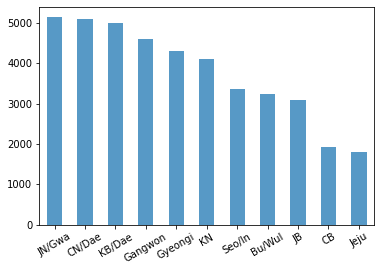

In [231]:
#사람들이 많이 가는 지방
df['SPOT'].value_counts().plot(kind='bar', alpha=0.75 ,rot=30);

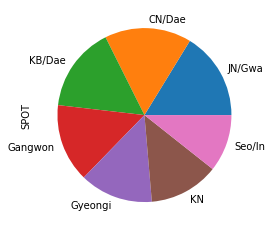

In [232]:
df['SPOT'].value_counts().head(7).plot(kind='pie');

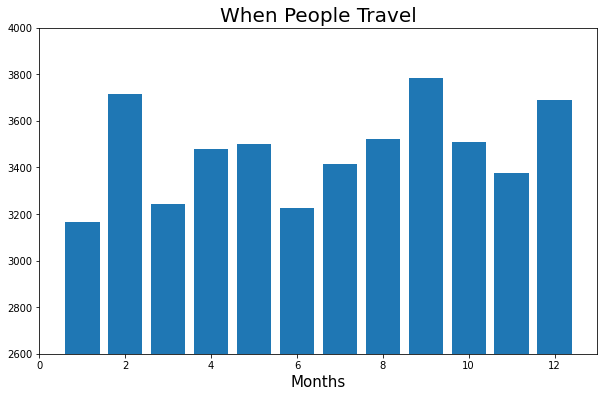

In [233]:
#사람들이 여행을 많이 가는 월
df['SMONTH'].value_counts().head(5)

smonth = df['SMONTH'].value_counts().sort_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

plt.bar(smonth.index, smonth)
plt.title('When People Travel', fontsize=20)
plt.xlabel('Months', fontsize=15)
plt.xlim(0,13)
plt.ylim(2600, 4000)
plt.show()

In [234]:
df_dn=pd.crosstab(index=df['DandN'], columns=df['SPOT'])
df_dn

SPOT,Bu/Wul,CB,CN/Dae,Gangwon,Gyeongi,JB,JN/Gwa,Jeju,KB/Dae,KN,Seo/In
DandN,,,,,,,,,,,
0,1434,1029,2926,1370,2715,1844,2651,240,2763,2188,1832
1,1798,896,2164,3222,1590,1254,2481,1560,2222,1910,1532


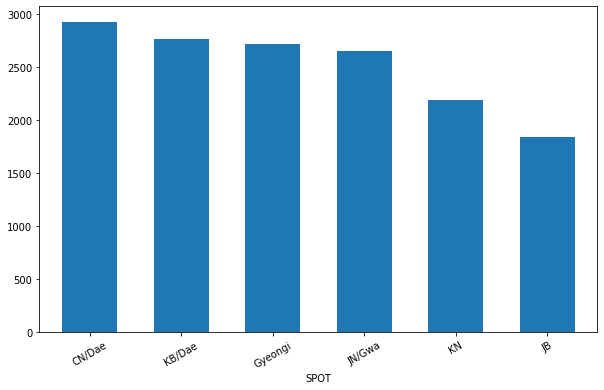

In [235]:
#당일치기 인기지역 TOP5
df_d = df_dn.loc[0].sort_values(ascending=False).head(6)

plt.rcParams['figure.figsize'] = [10, 6]
ax = df_d.plot.bar(width = 0.6, stacked=False, rot=30)

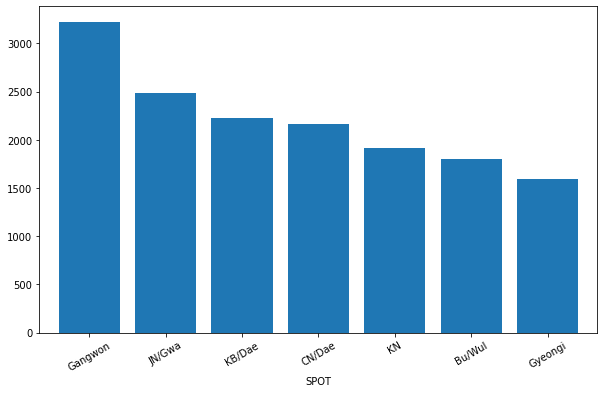

In [236]:
#1박이상 인기지역 TOP5
df_n =  df_dn.loc[1].sort_values(ascending=False).head(7)

ax = df_n.plot.bar(width = 0.8, stacked=False, rot=30)

In [237]:
df.groupby('SPOT')['M_TOTAL'].agg(['min','max','mean','median'])

,min,max,mean,median
SPOT,,,,
Bu/Wul,4000.0,1275000.0,141758.134412,100000.0
CB,3750.0,875000.0,98621.315844,75000.0
CN/Dae,5000.0,1127500.0,95467.880157,74500.0
Gangwon,3000.0,1300000.0,151990.877178,133750.0
Gyeongi,4000.0,1300000.0,92080.048780,70000.0
JB,5000.0,975000.0,98416.720077,80000.0
JN/Gwa,3333.0,1430000.0,114787.786763,90000.0
Jeju,3330.0,1800000.0,391276.437593,370000.0
KB/Dae,2500.0,1060000.0,103683.719057,75000.0


In [238]:
df['M_TOTAL'].agg(['min','max','mean','median'])

min       2.500000e+03
max       2.795000e+06
mean      1.249476e+05
median    9.000000e+04
Name: M_TOTAL, dtype: float64

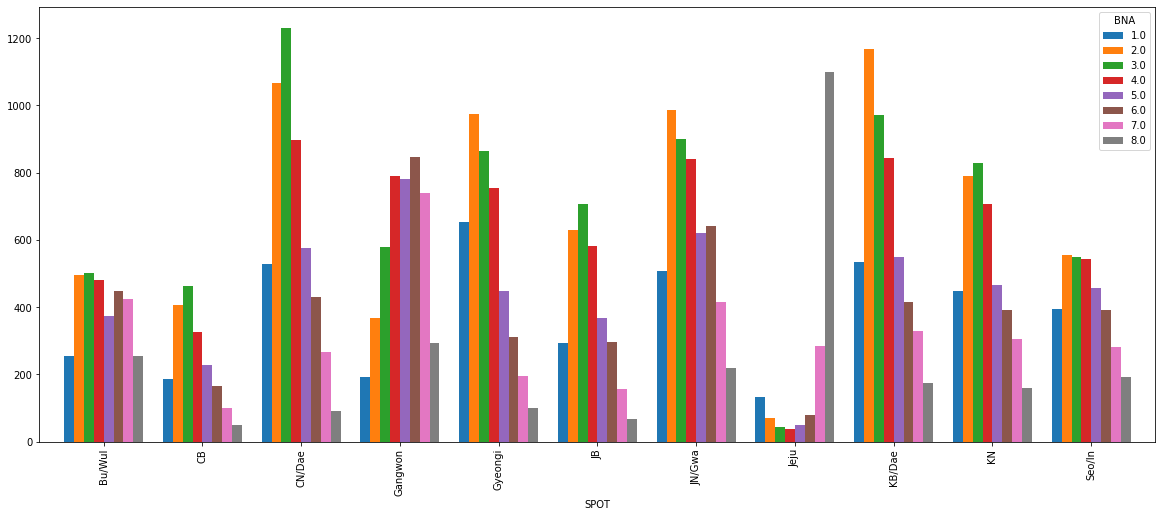

In [239]:
#여행객의 지출이 가장 큰 도시
money = pd.crosstab(index=df['SPOT'], columns=df['BNA'], aggfunc=None)
# money = money.rename_axis(None, axis=1)
# money = money.rename_axis(None, axis=0)
money

plt.rcParams['figure.figsize'] = [20, 8]
ax = money.plot.bar(width = 0.8, stacked=False)

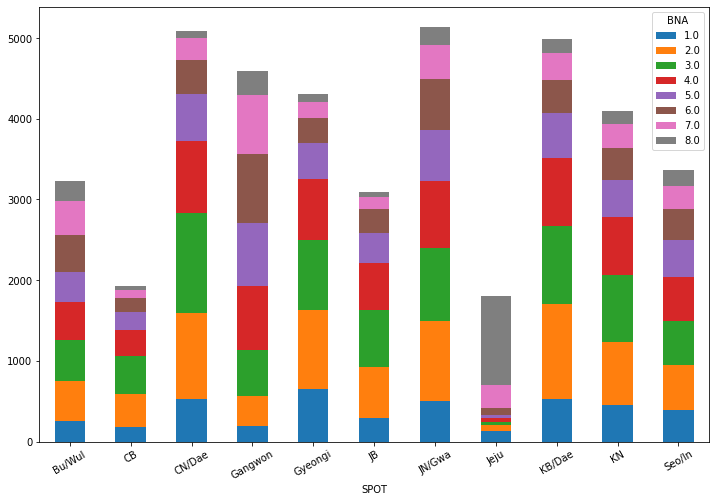

In [240]:
plt.rcParams['figure.figsize'] = [12, 8]
ax = money.plot.bar(width = 0.5, stacked=True, rot=30)

In [241]:
#사람들이 여행가는 이유
df['REASON'].value_counts()

etc           8115
View          7883
Time/Trans    7770
Famous        5928
Rec           5283
Food          3154
Budget        1854
Edu            704
Shopping       513
Conv           417
Name: REASON, dtype: int64

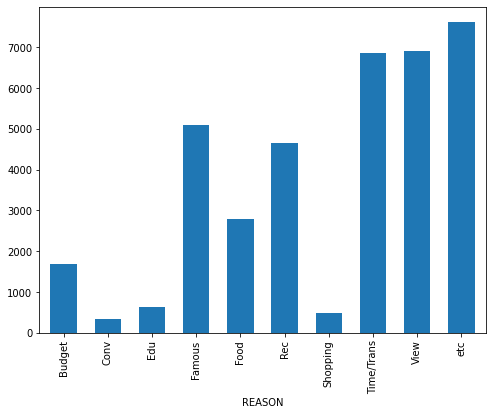

In [242]:
#강원도 여행 이유
reason = pd.crosstab((df['SPOT']=='Gangwon'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

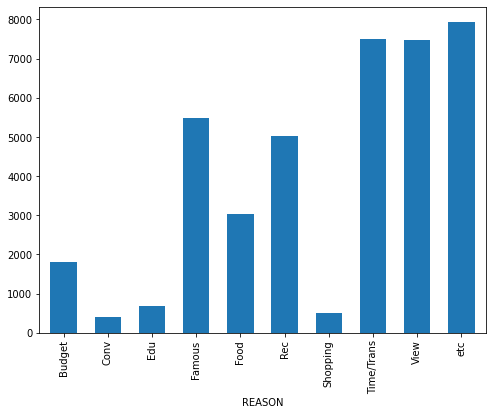

In [243]:
#제주도 여행 이유
reason = pd.crosstab((df['SPOT']=='Jeju'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

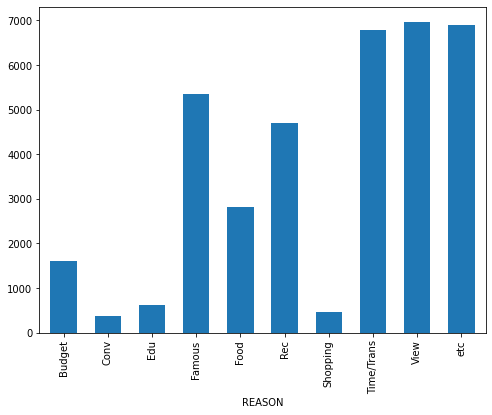

In [244]:
#충남 여행 이유
reason = pd.crosstab((df['SPOT']=='CN/Dae'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

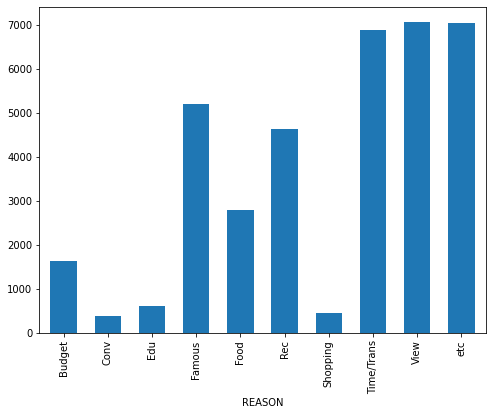

In [245]:
#경북 여행 이유
reason = pd.crosstab((df['SPOT']=='KB/Dae'), df['REASON'])
reason

plt.rcParams['figure.figsize'] = [8, 6]
ax = reason.iloc[0].plot.bar(width = 0.6, stacked=True)

In [246]:
!pip install -U pandas

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.5)


In [247]:
df_why=pd.crosstab(df['REASON'], df['SPOT'])
df_why.index.name = None
df_why

SPOT,Bu/Wul,CB,CN/Dae,Gangwon,Gyeongi,JB,JN/Gwa,Jeju,KB/Dae,KN,Seo/In
Budget,131,84,248,179,220,136,231,59,232,223,111
Conv,20,15,44,73,53,16,34,16,49,31,66
Edu,40,34,86,73,98,57,51,35,92,66,72
Famous,532,241,584,837,458,434,683,434,736,679,310
Food,287,90,338,372,226,342,563,115,363,307,151
Rec,412,223,594,639,486,382,710,260,646,562,369
Shopping,54,22,59,30,51,28,43,20,66,30,110
Time/Trans,555,348,995,904,1000,522,948,267,895,782,554
View,654,370,922,985,634,740,1056,411,825,772,514
etc,547,498,1220,500,1079,441,813,183,1081,646,1107


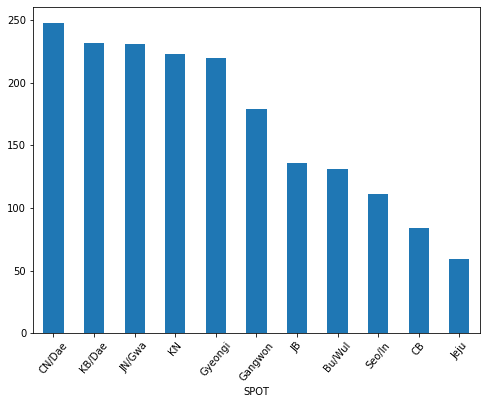

In [256]:
#쇼핑하러가는 도시
df_why2=df_why.loc['Shopping', : ].sort_values(ascending=False)
# df_why3.head(5).plot(kind='pie');
df_why3.plot(kind='bar', rot=50);
#경남>경기도>전남>경북>충남

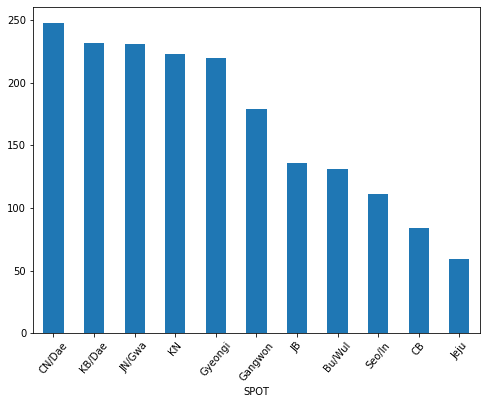

In [257]:
#저렴해서 방문하는 도시
df_why3=df_why.loc['Budget', : ].sort_values(ascending=False)
# df_why3.head(5).plot(kind='pie');
df_why3.plot(kind='bar', rot=50);
#경남>경기도>전남>경북>충남

[Text(0.5, 0, 'Cost Category'), Text(0.5, 1.0, 'Visitor')]

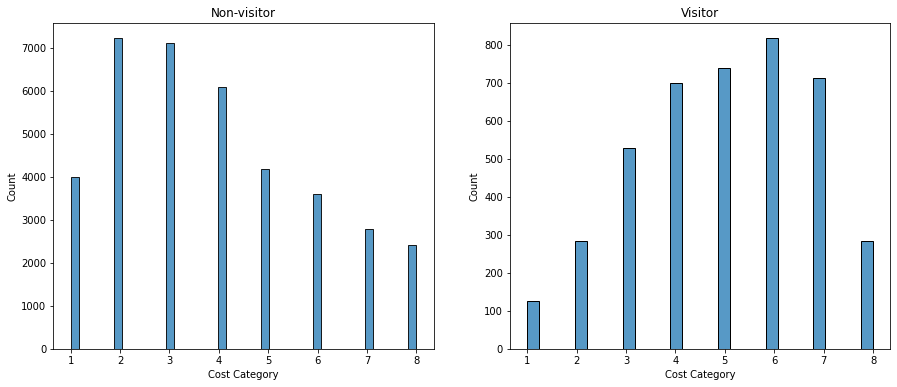

In [259]:
# 강원도 방문 여부에 따른 사용액 범주
non_visit = df[df.Gangwon==False]['BNA']
visit = df[df.Gangwon==True]['BNA']


import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15,6))
sns.histplot(non_visit, ax=ax[0]);
sns.histplot(visit, ax=ax[1]);

ax[0].set(xlabel='Cost Category', title="Non-visitor")
ax[1].set(xlabel='Cost Category', title="Visitor")

In [260]:
df.groupby('Gangwon')['ONE_TCOST'].agg(['count','mean','median','max','min'])
#강원도에 다녀온 사람의 평균 지출이 그렇지 않은 사람보다 높다.

,count,mean,median,max,min
Gangwon,,,,,
False,37431,128701.913268,94000.0,3500000.0,2500.0
True,4190,165765.443357,150000.0,2500000.0,3000.0


[Text(0.5, 0, 'Month'), Text(0.5, 1.0, 'Visitor')]

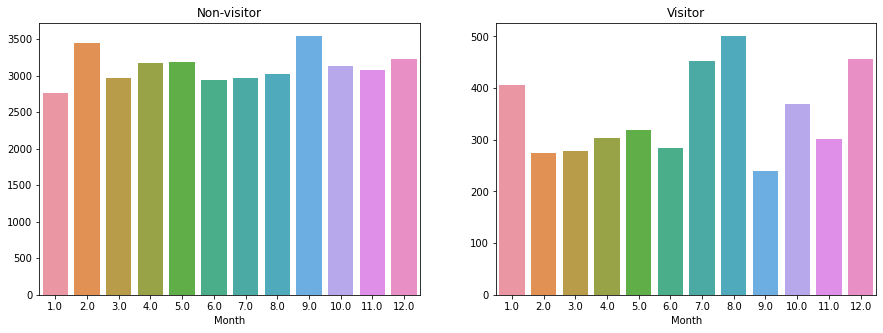

In [261]:
#강원도에 가장 많이 가는 월
non_vmonth = df[df.Gangwon==False]['SMONTH'].value_counts()
vmonth = df[df.Gangwon==True]['SMONTH'].value_counts()

nvm = non_vmonth.sort_index()
vn = vmonth.sort_index()

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=nvm.index, y=nvm.values, ax=ax[0]);
sns.barplot(x=vn.index, y=vn.values, ax=ax[1]);

ax[0].set(xlabel='Month', title="Non-visitor")
ax[1].set(xlabel='Month', title="Visitor")

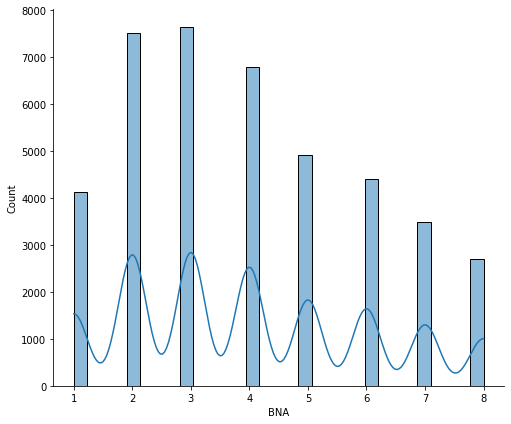

In [262]:
sns.displot(data=df['BNA'].sort_values(), height=6, aspect=1.2, kde=True);

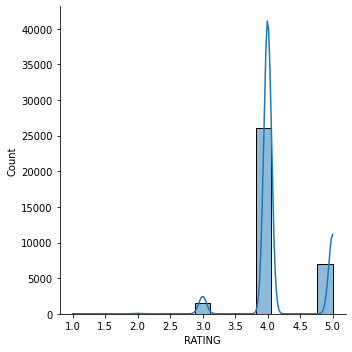

In [263]:
#만족도는 응답자 편향이 너무 심해서 분석에 쓰기 어렵겠다...
sns.displot(df['RATING'],kde=True);
# plt.axvline(3.7, color='red');

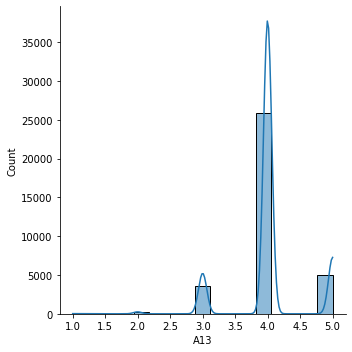

In [264]:
#재방문의사
sns.displot(df['A13'],kde=True);

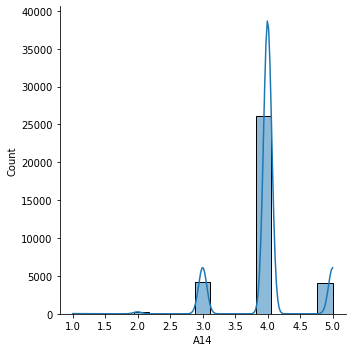

In [265]:
#추천의도
sns.displot(df['A14'],kde=True);

# **3. 데이터 모델링**

## **3-1 모델링 데이터(mdf) engineering**

In [627]:
df.columns.unique()

Index(['ID', 'SMONTH', 'S_Day', 'TCOST', 'TNUM', 'ONE_TCOST', 'CASE', 'SPOT',
       'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2', 'A7B_3', 'A7B_4', 'A7B_5',
       'A7B_6', 'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D', 'NA10E', 'NA10F',
       'NA10G', 'NA_TOTAL', 'RATING', 'A13', 'A14', 'DQ5', 'DQ6', 'SEX',
       'BAGE', 'BARA', 'EXP_NIGHT', 'EXP_ADAY', 'A7B', 'M_TOTAL', 'BNA',
       'DandN', 'REASON', 'Gangwon'],
      dtype='object')

In [628]:
mdf=df[['SMONTH', 'S_Day', 'TNUM', 'A7B', 'SPOT', 'DandN', 'REASON', 'BNA', 'M_TOTAL',
        'SEX', 'BAGE', 'Gangwon']]

In [629]:
mdf.shape

(41621, 12)

In [630]:
mdf['TNUM'].fillna(mdf['TNUM'].mean(), inplace=True)
mdf.isnull().sum()

SMONTH     0
S_Day      0
TNUM       0
A7B        0
SPOT       0
DandN      0
REASON     0
BNA        0
M_TOTAL    0
SEX        0
BAGE       0
Gangwon    0
dtype: int64

In [631]:
mdf.head()

,SMONTH,S_Day,TNUM,A7B,SPOT,DandN,REASON,BNA,M_TOTAL,SEX,BAGE,Gangwon
0,7.0,2.0,5.0,Mate,Jeju,1,Time/Trans,8.0,360000.0,2,6,False
1,5.0,0.0,33.0,Crew,CN/Dae,0,View,3.0,57200.0,2,5,False
2,5.0,0.0,5.0,Mate,Gyeongi,0,etc,4.0,90000.0,1,7,False
3,5.0,2.0,5.0,Fam,JB,1,Time/Trans,3.0,68500.0,2,6,False
4,9.0,1.0,5.0,Mate,JN/Gwa,1,View,4.0,100000.0,2,6,False


## **3-2 기준모델 _ Gangwon**


In [636]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)
train.shape, test.shape

((33296, 12), (8325, 12))

In [637]:
target = 'Gangwon'
features = mdf.columns.drop([target, 'SPOT'])

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_train.columns

Index(['SMONTH', 'S_Day', 'TNUM', 'A7B', 'DandN', 'REASON', 'BNA', 'M_TOTAL',
       'SEX', 'BAGE'],
      dtype='object')

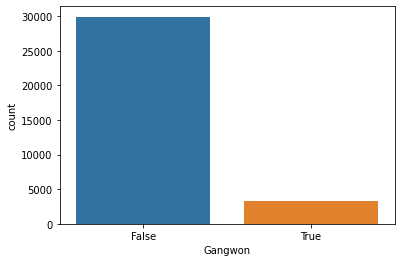

In [638]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=y_train);

# 분류문제,  타겟 클래스비율이 70% 이상 차이나서 정확도 만으로는 판단할 수 없음
# 정밀도, 재현율, ROC curve, AUC 등을 같이 사용해야 함

In [639]:
#기준모델_최빈값
major = y_train.mode()[0]
y_pred = [major] * len(y_train)

from sklearn.metrics import accuracy_score
print("훈련 정확도: ", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

y_val = val[target]
y_pred = [major] * len(y_val)
print("검증 정확도: ", accuracy_score(y_val, y_pred))

훈련 정확도:  0.8990869774147044
              precision    recall  f1-score   support

       False       0.90      1.00      0.95     29936
        True       0.00      0.00      0.00      3360

    accuracy                           0.90     33296
   macro avg       0.45      0.50      0.47     33296
weighted avg       0.81      0.90      0.85     33296

검증 정확도:  0.8968468468468469


## (열지 마시오) 수치형 특성만 / 선형회귀모델 (열지 마시오)

In [ ]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41621 entries, 0 to 41623
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMONTH   41621 non-null  float64
 1   S_Day    41621 non-null  float64
 2   TNUM     39135 non-null  float64
 3   A7B      41621 non-null  int64  
 4   SPOT     41621 non-null  int64  
 5   DandN    41621 non-null  int64  
 6   REASON   41621 non-null  int64  
 7   BNA      41621 non-null  float64
 8   M_TOTAL  41621 non-null  float64
 9   SEX      41621 non-null  int64  
 10  BAGE     41621 non-null  int64  
 11  BARA     41621 non-null  int64  
 12  DQ5      41621 non-null  int64  
 13  Gangwon  41621 non-null  bool   
dtypes: bool(1), float64(5), int64(8)
memory usage: 4.5 MB


In [ ]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

# 숫자형 특성
features = ['SMONTH', 'S_Day', 'TNUM', 'M_TOTAL']
X_train = train[features]
X_val = val[features]


from sklearn.impute import SimpleImputer

imputer = SimpleImputer() 
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

linear_model.fit(X_train_imputed, y_train)
pred = linear_model.predict(X_val_imputed)

In [ ]:
pd.Series(linear_model.coef_, features)
#연말 / 장기 / 다수 / 고액 일수록 강원도에

SMONTH     2.108374e-03
S_Day      1.454110e-02
TNUM       2.108440e-03
M_TOTAL    1.631762e-07
dtype: float64

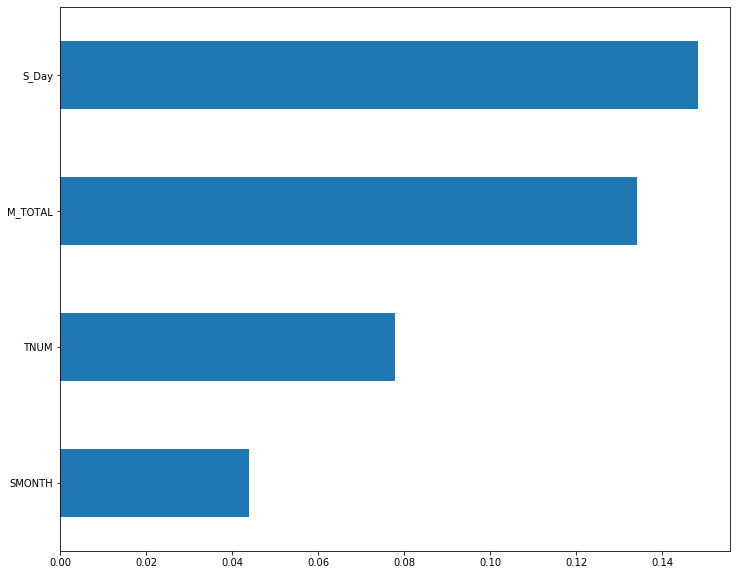

In [ ]:
plt.figure(figsize=(12, 10))
coefficients.sort_values().plot.barh();

In [ ]:
#12월, 5일간, 5명이, 50만원
test_case = [[12, 5, 120, 10000000]]
linear_model.predict(test_case)

array([2.03162264])

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_imputed, y_train)

print('검증세트 정확도', logistic.score(X_val_imputed, y_val))

검증세트 정확도 0.8968468468468469


In [ ]:
pred = logistic.predict(X_val_imputed)
pred

logistic.predict(test_case)
#틀렸네..?

array([False])

In [ ]:
print(features)
print(logistic.coef_)
#수치도 변하고 방향도 변했네...?

['SMONTH', 'S_Day', 'TNUM', 'M_TOTAL']
[[-6.95732778e-09 -3.91356759e-11 -2.98490505e-09 -1.30353780e-05]]


## **3-3 파이프라인_홀드아웃(8:2)**

In [640]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)
train.shape, test.shape

train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

target = 'Gangwon'
features = mdf.columns.drop([target, 'SPOT', 'BNA'])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
X_train.shape

(26636, 9)

In [641]:
X_train.columns

Index(['SMONTH', 'S_Day', 'TNUM', 'A7B', 'DandN', 'REASON', 'M_TOTAL', 'SEX',
       'BAGE'],
      dtype='object')

In [642]:
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pipe1 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), #결측치 TNUM
    RandomForestClassifier(#max_depth=10, class_weight='balanced', 
                           n_estimators=50, random_state=2, n_jobs=-1)
)

pipe1.fit(X_train, y_train)
print('훈련 정확도: ', pipe1.score(X_train, y_train))
print('검증 정확도: ', pipe1.score(X_val, y_val))

훈련 정확도:  0.9968088301546779
검증 정확도:  0.8884384384384384


Text(0.5, 1.0, 'Confusion matrix, n = 6660')

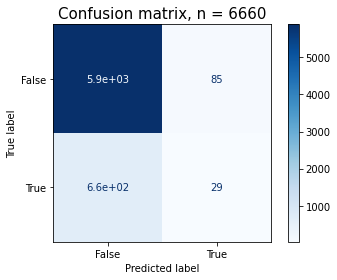

In [643]:
# 타겟의 경우 진짜 강원도임을 찾는 정밀도(precision)가 중요하다

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe1, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
#아닌게 실제로 많아서, 일단 아니라고 하면 아닐 확률이 높은 상태

In [644]:
pipe2 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    StandardScaler(),
    RandomForestClassifier(max_depth=10, class_weight='balanced', 
                           n_estimators=50, random_state=2, n_jobs=-1)
)

pipe2.fit(X_train, y_train)

#True 범주의 수치
from sklearn.metrics import classification_report

y_pred = pipe2.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.95      0.72      0.82      5973
        True       0.21      0.65      0.32       687

    accuracy                           0.71      6660
   macro avg       0.58      0.68      0.57      6660
weighted avg       0.87      0.71      0.77      6660



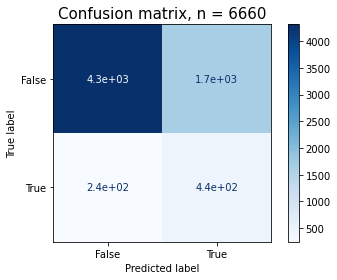

In [645]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe2, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [646]:
import numpy as np

cm = pcm.confusion_matrix
cm

correct_predictions = np.diag(cm).sum()
correct_predictions

total_predictions = cm.sum()
total_predictions

print(correct_predictions/total_predictions) #분류 정확도
print('검증 정확도: ', accuracy_score(y_val, y_pred))

0.7145645645645645
검증 정확도:  0.7145645645645645


In [647]:
from sklearn.metrics import roc_curve

# roc_curve(타겟값, prob of 1)
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
roc

,FPR(Fall-out),TPRate(Recall),Threshold
0,0.000000,0.000000,1.830054
1,0.000167,0.000000,0.830054
2,0.000167,0.001456,0.829528
3,0.000335,0.001456,0.827115
4,0.000335,0.004367,0.821133
...,...,...,...
1291,0.885150,1.000000,0.000790
1292,0.889001,1.000000,0.000629
1293,0.894860,1.000000,0.000566
1294,0.910263,1.000000,0.000253


AUC score:  0.7519853411189752


Text(0, 0.5, 'TPR(Recall)')

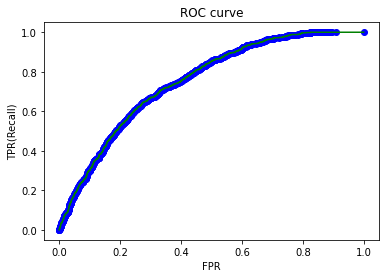

In [648]:
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe2.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR(Recall)')

In [649]:
#최적의 임계값
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

y_pred_optimal = y_pred_proba >= optimal_threshold
print(classification_report(y_val, y_pred_optimal))

idx: 796 , threshold: 0.4565740292639934
              precision    recall  f1-score   support

       False       0.95      0.67      0.78      5973
        True       0.20      0.71      0.31       687

    accuracy                           0.67      6660
   macro avg       0.57      0.69      0.55      6660
weighted avg       0.87      0.67      0.74      6660



In [650]:
from ipywidgets import interact, fixed

y_pred_proba = pipe2.predict_proba(X_val)[:, 1]
def explore_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba >= threshold
    vc = pd.Series(y_pred).value_counts()
    ax = sns.histplot(y_pred_proba, kde=True)
    ax.axvline(threshold, color='red')
    ax.set_title(f'# of target, 1={vc[1]}, 0={vc[0]}')
    plt.show()
    print(classification_report(y_true, y_pred))

    
interact(explore_threshold, 
    y_true=fixed(y_val), 
    y_pred_proba=fixed(y_pred_proba), 
    threshold=(0, 1, 0.01));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [651]:
#높을 수록 좋은 auc...
from sklearn.metrics import roc_auc_score
print('auc_score :', roc_auc_score(y_val, y_pred_proba))

auc_score : 0.7519853411189752


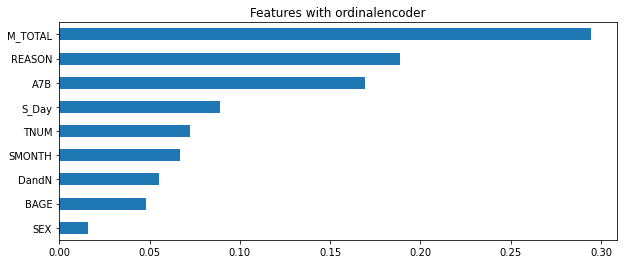

In [652]:
import matplotlib.pyplot as plt

rf = pipe2.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

plt.figure(figsize=(10,4))
plt.title(f'Features with ordinalencoder')
importances.sort_values().plot.barh();

## **3-4 파이프라인_교차검증**

In [517]:
mdf.columns

Index(['SMONTH', 'S_Day', 'TNUM', 'A7B', 'SPOT', 'DandN', 'REASON', 'BNA',
       'M_TOTAL', 'SEX', 'BAGE', 'Gangwon'],
      dtype='object')

In [518]:
target='Gangwon'
features = mdf.columns.drop([target, 'SPOT', 'M_TOTAL'])

from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)
train.shape, test.shape

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
X_train.shape, y_train.shape

((33296, 9), (33296,))

In [519]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((33296, 9), (33296,), (8325, 9), (8325,))

## **최적의 하이퍼파라미터 (XGBClassifier, RandomizedSearchCV)**

In [377]:
y_train.value_counts(normalize=True)
ratio = 0.1/0.89

In [378]:
#하이퍼파라미터 튜닝
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import cross_val_score
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

pipe = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    XGBClassifier(n_jod=-1, scale_pos_weight=ratio)
)

dists = {
    'targetencoder__smoothing': [20.,50.,60.,100.,500.],
    'targetencoder__min_samples_leaf': randint(1, 10),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'xgbclassifier__n_estimators': randint(50, 100, 600), 
    'xgbclassifier__learning_rate': [1.5, 1.2, 0.8, 0.5], 
    'xgbclassifier__max_depth': randint(3, 20)
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='precision',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 45.4min finished


In [380]:
print(f'Best score(precision): {clf.best_score_}')
print(f'Best model: {clf.best_params_}')

Best score(precision): 0.2826599705903802
Best model: {'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 9, 'targetencoder__smoothing': 20.0, 'xgbclassifier__learning_rate': 1.5, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 651}


In [466]:
pipe = clf.best_estimator_

train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)

print('훈련 정확도: ', accuracy_score(y_train, train_pred))
print('시험 정확도: ', accuracy_score(y_test, test_pred))

print('\nClassification Report:')
print(classification_report(y_test, test_pred))

훈련 정확도:  0.9057844786160499
시험 정확도:  0.8981381381381381

Classification Report:
              precision    recall  f1-score   support

       False       0.90      1.00      0.95      7495
        True       0.22      0.01      0.02       830

    accuracy                           0.90      8325
   macro avg       0.56      0.50      0.48      8325
weighted avg       0.83      0.90      0.85      8325



## **하이퍼파라미터2 (RandomForestClassifier, RandomizedSearchCV)**

In [582]:
mdf.isnull().sum()

SMONTH     0
S_Day      0
TNUM       0
A7B        0
SPOT       0
DandN      0
REASON     0
BNA        0
M_TOTAL    0
SEX        0
BAGE       0
Gangwon    0
dtype: int64

In [583]:
features, labels = mdf.drop('Gangwon', 1), mdf['Gangwon']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state=7)

In [585]:
accuracies = {} #성능 비교용
TargetEncoder().fit(X_train, y_train)

rf_model = make_pipeline(
    TargetEncoder(),
    RandomForestClassifier(random_state = 10))
rf_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['A7B', 'SPOT', 'REASON'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return_df=True, smoothing=1.0, verbose=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                        

In [586]:
rf_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score

model_metrics = {}

model_metrics['rf: 정확도'] = accuracy_score(y_test, rf_pred)
model_metrics['rf: Precision'] = precision_score(y_test, rf_pred)
model_metrics['rf: Recall'] = recall_score(y_test, rf_pred)

pd.DataFrame([model_metrics])

,rf: 정확도,rf: Precision,rf: Recall
0,0.998318,0.985525,0.997558


In [587]:
from sklearn.metrics import confusion_matrix

ndf_cm = confusion_matrix(y_test, rf_pred)
print(ndf_cm)

[[7494   12]
 [   2  817]]


In [590]:
test_scores, train_scores = [], []

for i in range(10, 100, 10):
  rf_model = make_pipeline(
    TargetEncoder(),
    RandomForestClassifier(class_weight='balanced',n_estimators = 100, random_state = 10))
  rf_model.fit(X_train, y_train)

  train_preds = rf_model.predict(X_train)
  test_preds  = rf_model.predict(X_test)
  
  train_scores.append(round(accuracy_score(y_train, train_preds), 1))
  test_scores.append(round(accuracy_score(y_test, test_preds), 1))

In [602]:
rf_ndf = pd.DataFrame({'train': train_scores,
                          'test': test_scores})
rf_ndf

,train,test
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
5,1.0,1.0
6,1.0,1.0
7,1.0,1.0
8,1.0,1.0


## **3-4 특성중요도**

In [659]:
target='Gangwon'
features = mdf.columns.drop([target, 'SPOT'])

from sklearn.model_selection import train_test_split
train, test = train_test_split(mdf, test_size=0.2, random_state=2)

train, val = train_test_split(train, test_size=0.2, random_state=2)


X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [660]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:0.43673	validation_1-rmse:0.437349
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.39083	validation_1-rmse:0.392043
[2]	validation_0-rmse:0.358207	validation_1-rmse:0.360029
[3]	validation_0-rmse:0.335411	validation_1-rmse:0.337688
[4]	validation_0-rmse:0.320008	validation_1-rmse:0.322693
[5]	validation_0-rmse:0.30958	validation_1-rmse:0.312686
[6]	validation_0-rmse:0.30257	validation_1-rmse:0.306025
[7]	validation_0-rmse:0.297947	validation_1-rmse:0.301644
[8]	validation_0-rmse:0.294892	validation_1-rmse:0.298779
[9]	validation_0-rmse:0.292873	validation_1-rmse:0.296939
[10]	validation_0-rmse:0.291508	validation_1-rmse:0.295743
[11]	validation_0-rmse:0.290598	validation_1-rmse:0.294946
[12]	validation_0-rmse:0.28994	validation_1-rmse:0.294396
[13]	validation_0-rmse:0.289488	validation_1-rmse:0.29406
[14]	validation_0-rmse:0.289172

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [661]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))

R^2 0.07468054058346607


In [663]:
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_val_encoded, 
    model_features=X_val.columns, 
    feature=feature,
    # grid point를 크게 주면 겹치는 점이 생겨 Number of unique grid points는 grid point 보다 작을 수 있습니다.
    num_grid_points=100, # grid 포인트를 더 줄 수 있습니다. default = 10
)

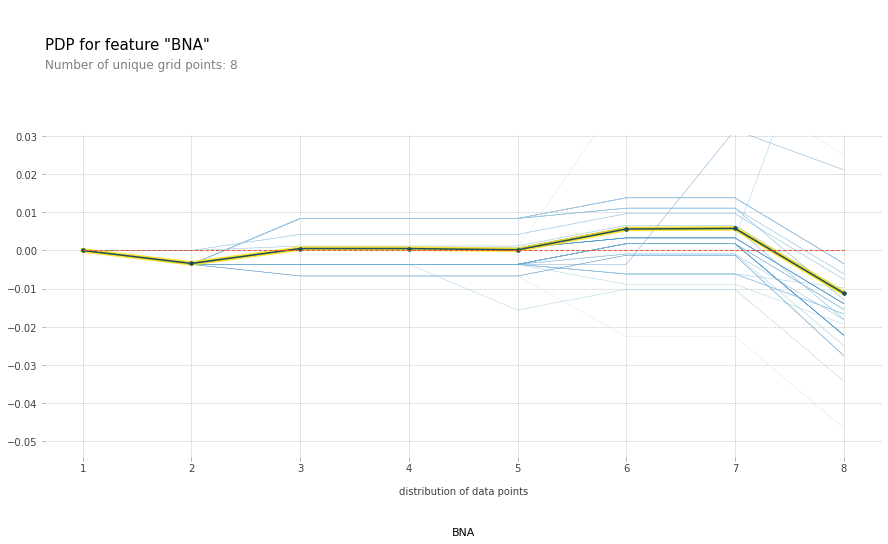

In [664]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01 # ICE curves는 100개
         , plot_pts_dist=True )

plt.xlim(20000,150000);

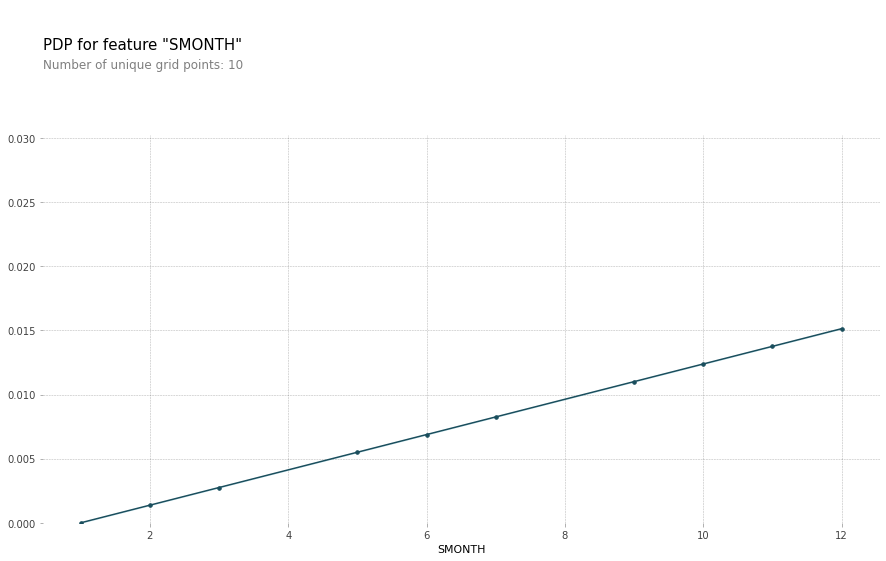

In [671]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.linear_model import LinearRegression

feature = 'SMONTH'

linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)
linear.fit(X_train, y_train)

isolated = pdp_isolate(
    model=linear, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

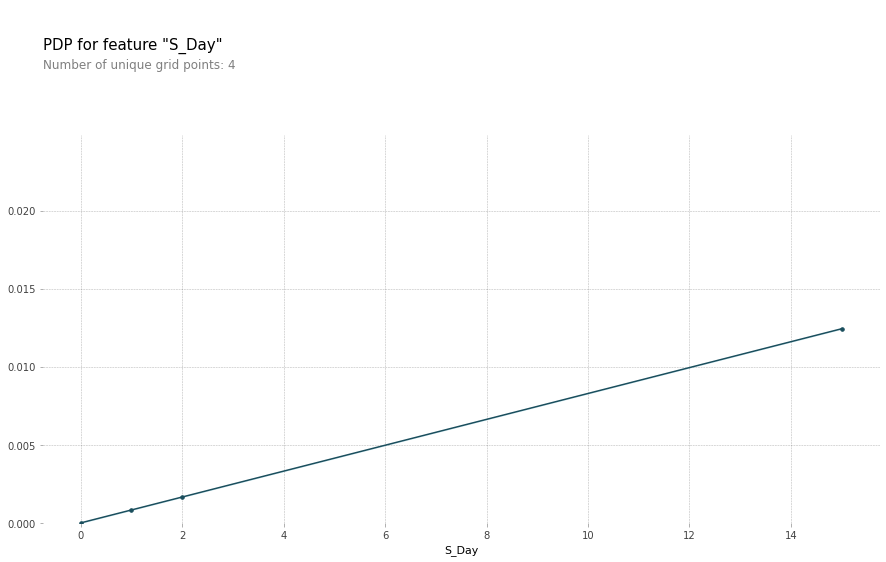

In [672]:
feature = 'S_Day'

isolated = pdp_isolate(
    model=linear, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

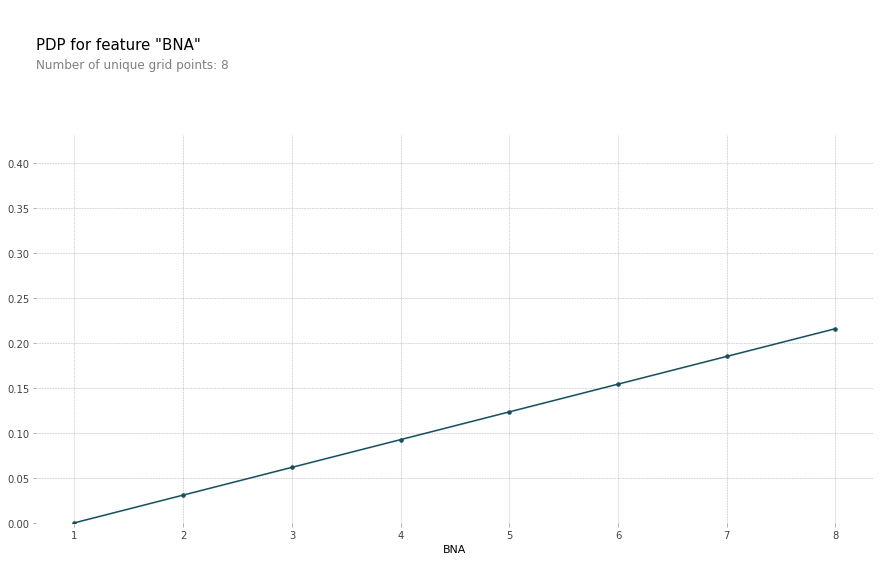

In [673]:
feature = 'BNA'

linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)
linear.fit(X_train, y_train)

isolated = pdp_isolate(
    model=linear, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [665]:
features = ['SMONTH', 'M_TOTAL']

,SMONTH,M_TOTAL,preds
0,1.0,3.750000e+03,0.081939
1,1.0,3.267000e+04,0.063065
2,1.0,5.000000e+04,0.080496
3,1.0,6.000000e+04,0.079049
4,1.0,7.929111e+04,0.107636
...,...,...,...
95,12.0,1.000000e+05,0.113571
96,12.0,1.250000e+05,0.156381
97,12.0,1.667433e+05,0.173566
98,12.0,2.400644e+05,0.185778


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


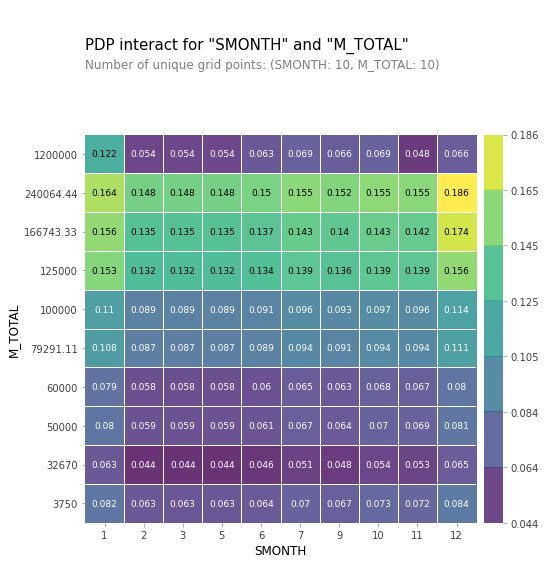

In [668]:
interaction = pdp_interact(
    model=boosting, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);
                  
interaction.pdp

In [674]:
mdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41621 entries, 0 to 41623
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMONTH   41621 non-null  float64
 1   S_Day    41621 non-null  float64
 2   TNUM     41621 non-null  float64
 3   A7B      41621 non-null  object 
 4   SPOT     41621 non-null  object 
 5   DandN    41621 non-null  int64  
 6   REASON   41621 non-null  object 
 7   BNA      41621 non-null  float64
 8   M_TOTAL  41621 non-null  float64
 9   SEX      41621 non-null  int64  
 10  BAGE     41621 non-null  int64  
 11  Gangwon  41621 non-null  bool   
dtypes: bool(1), float64(5), int64(3), object(3)
memory usage: 3.9+ MB


In [681]:
target='Gangwon'
features = mdf.columns.drop(['S_Day', 'TNUM', 'M_TOTAL', 'Gangwon'])

X = mdf[features]
y = mdf[target]

pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe.fit(X, y);

In [682]:
encoder = pipe.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X)
rf = pipe.named_steps['randomforestclassifier']

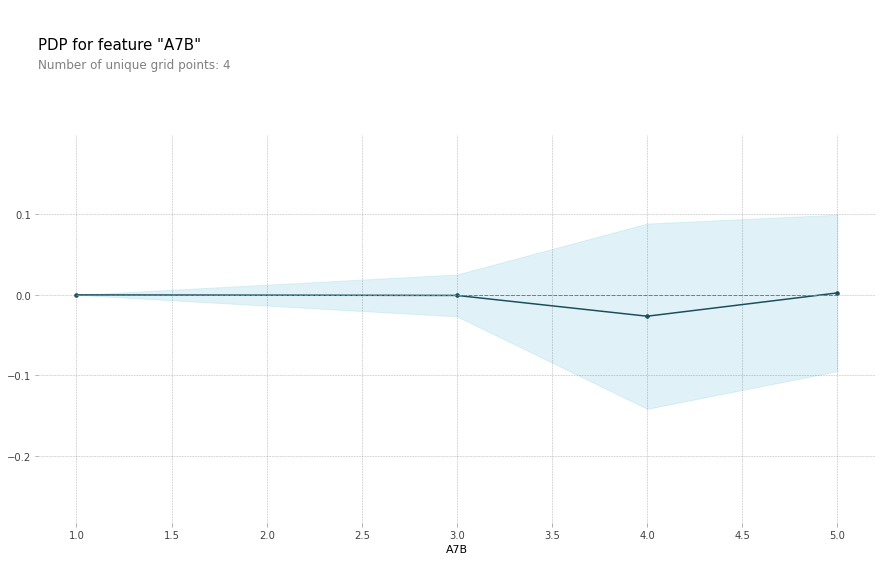

In [684]:
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'A7B'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

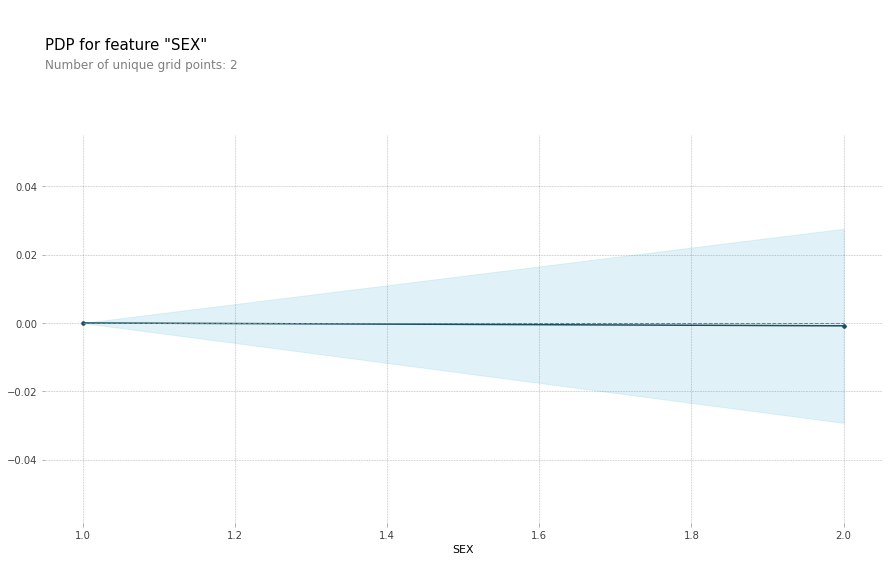

In [685]:
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'SEX'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [691]:
encoder.mapping

[{'col': 'A7B', 'data_type': dtype('O'), 'mapping': Mate     1
  Crew     2
  Fam      3
  Etc      4
  B_Fam    5
  NaN     -2
  dtype: int64},
 {'col': 'SPOT', 'data_type': dtype('O'), 'mapping': Jeju        1
  CN/Dae      2
  Gyeongi     3
  JB          4
  JN/Gwa      5
  Gangwon     6
  Seo/In      7
  Bu/Wul      8
  CB          9
  KN         10
  KB/Dae     11
  NaN        -2
  dtype: int64},
 {'col': 'REASON', 'data_type': dtype('O'), 'mapping': Time/Trans     1
  View           2
  etc            3
  Food           4
  Rec            5
  Famous         6
  Budget         7
  Edu            8
  Conv           9
  Shopping      10
  NaN           -2
  dtype: int64}]

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f21cee36b50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f21cdf80450>})

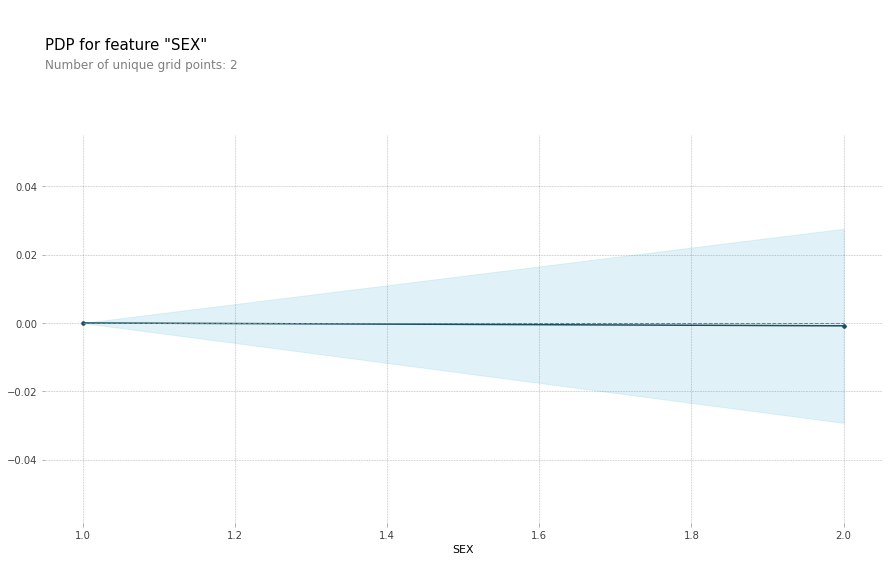

In [696]:
feature = 'SEX'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

pdp.pdp_plot(pdp_dist, feature)

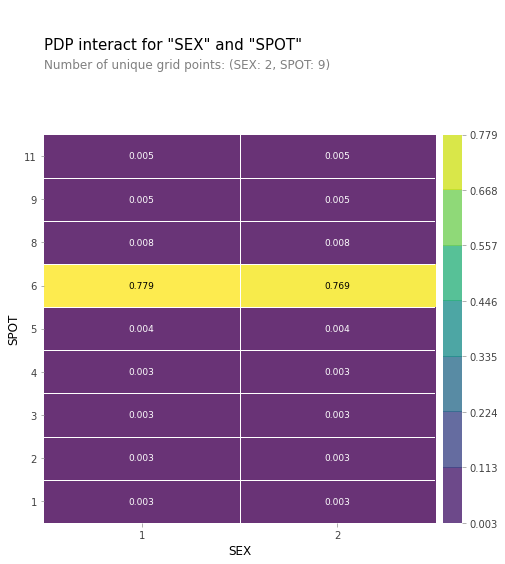

In [698]:
features = ['SEX', 'SPOT']

interaction = pdp_interact(
    model=rf, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

# **SHAP**

In [769]:
df.columns

Index(['ID', 'SMONTH', 'S_Day', 'TCOST', 'TNUM', 'ONE_TCOST', 'CASE', 'SPOT',
       'A2_1', 'A2_2', 'A2_3', 'A7B_1', 'A7B_2', 'A7B_3', 'A7B_4', 'A7B_5',
       'A7B_6', 'PRE_TOTAL', 'NA10A', 'NA10C', 'NA10D', 'NA10E', 'NA10F',
       'NA10G', 'NA_TOTAL', 'RATING', 'A13', 'A14', 'DQ5', 'DQ6', 'SEX',
       'BAGE', 'BARA', 'EXP_NIGHT', 'EXP_ADAY', 'A7B', 'M_TOTAL', 'BNA',
       'DandN', 'REASON', 'Gangwon'],
      dtype='object')

In [804]:
ndf=df[['ID','SMONTH', 'S_Day', 'ONE_TCOST', 'BARA', 'M_TOTAL', 'BNA', 'DandN', 'REASON', 'Gangwon']]
ndf=ndf[(ndf['ONE_TCOST'] >= np.percentile(ndf['ONE_TCOST'], 0.5)) & 
        (ndf['ONE_TCOST'] <= np.percentile(ndf['ONE_TCOST'], 99.5)) &
        (ndf['M_TOTAL'] >= np.percentile(ndf['M_TOTAL'], 0.5)) & 
        (ndf['M_TOTAL'] <= np.percentile(ndf['M_TOTAL'], 99.5))]

ndf.shape
train, test = train_test_split(ndf, test_size=0.2, random_state=2)

In [805]:
train.columns
train.isnull().sum()
# train.shape

ID           0
SMONTH       0
S_Day        0
ONE_TCOST    0
BARA         0
M_TOTAL      0
BNA          0
DandN        0
REASON       0
Gangwon      0
dtype: int64

In [806]:
target = 'Gangwon'
X= ndf.drop(columns=target)
y= ndf[target]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000
    , stratify=y
    , random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000
    , stratify=y_train_val
    , random_state=42)

In [807]:
test_id = X_test['ID']

In [808]:
y_train.value_counts(normalize=True)

False    0.899049
True     0.100951
Name: Gangwon, dtype: float64

In [809]:
ratio = 0.10/0.89
ratio

0.11235955056179776

In [810]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.644502	validation_1-auc:0.638979
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.645107	validation_1-auc:0.638819
[2]	validation_0-auc:0.645107	validation_1-auc:0.638819
[3]	validation_0-auc:0.668812	validation_1-auc:0.664656
[4]	validation_0-auc:0.668812	validation_1-auc:0.664656
[5]	validation_0-auc:0.676208	validation_1-auc:0.673703
[6]	validation_0-auc:0.681928	validation_1-auc:0.678809
[7]	validation_0-auc:0.68362	validation_1-auc:0.679949
[8]	validation_0-auc:0.692287	validation_1-auc:0.687312
[9]	validation_0-auc:0.692608	validation_1-auc:0.687585
[10]	validation_0-auc:0.692978	validation_1-auc:0.687788
[11]	validation_0-auc:0.738491	validation_1-auc:0.735321
[12]	validation_0-auc:0.746477	validation_1-auc:0.744531
[13]	validation_0-auc:0.747385	validation_1-auc:0.745775
[14]	validation_0-auc:0.747394	validation_1-auc:0.745764

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.11235955056179776,
              seed=None, silent=None, subsample=1, verbosity=0)

In [811]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba))

Test AUC for class "True":
0.8382294408528728


In [812]:
from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.90      1.00      0.95      8990
        True       0.00      0.00      0.00      1010

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000



In [813]:
ndf.columns

Index(['ID', 'SMONTH', 'S_Day', 'ONE_TCOST', 'BARA', 'M_TOTAL', 'BNA', 'DandN',
       'REASON', 'Gangwon'],
      dtype='object')

In [827]:
import xgboost
import shap

row = X_test.iloc[[3160]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit')

In [815]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [816]:
print('강원도에 다녀왔다 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('강원도에 안갔다 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

fully paid 예측에 대한 Positive 요인 Top 3 입니다:
1. REASON : View
2. ONE_TCOST : 500000.0
3. BNA : 8.0


Negative 요인 Top 3 입니다:
1. M_TOTAL : 621680.0
2. BARA : 25
3. ID : 2503073132A_1139629


In [823]:
def explain(row_number):
    positive_class = 'True'
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [824]:
explain(3200)

예측결과는 False 으로, 확률은 100% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. BARA : 39
2. S_Day : 5.0
3. ID : 39010651391_1350780


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. REASON : View
2. M_TOTAL : 380000.0
3. BNA : 8.0


In [825]:
explain(1800)

예측결과는 False 으로, 확률은 98% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. ONE_TCOST : 75600.0
2. ID : 3101371128A_1237843
3. S_Day : 0.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. BARA : 31
2. REASON : Famous
3. SMONTH : 8.0
